<Axes: >

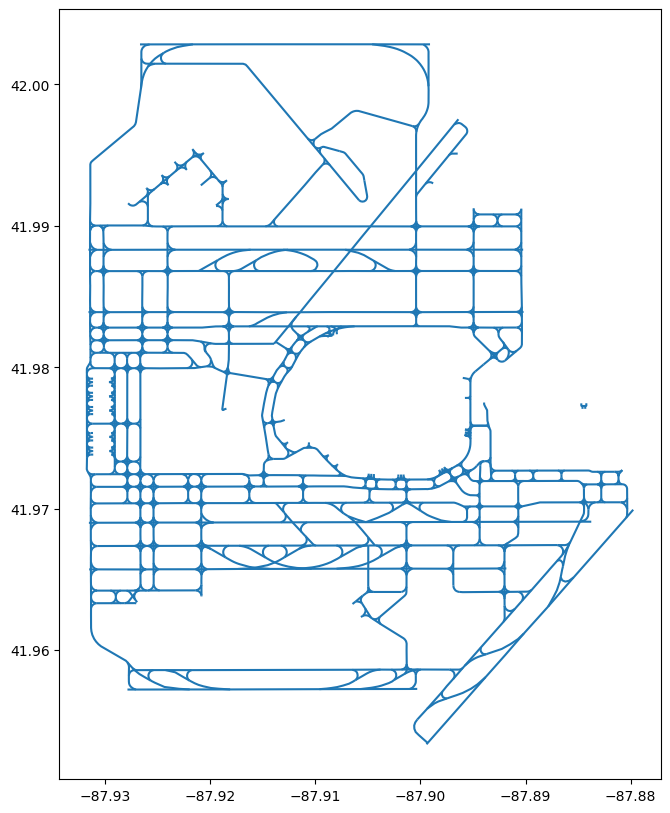

In [5]:
import osmnx as ox

# defines tags and place
tags = {"aeroway": ["taxiway", "runway"]}
place = "O'Hare International Airport, Chicago, Illinois, USA"

# gets geospatial data
gdf = ox.features_from_place(place, tags)

gdf.plot(figsize=(10, 10))

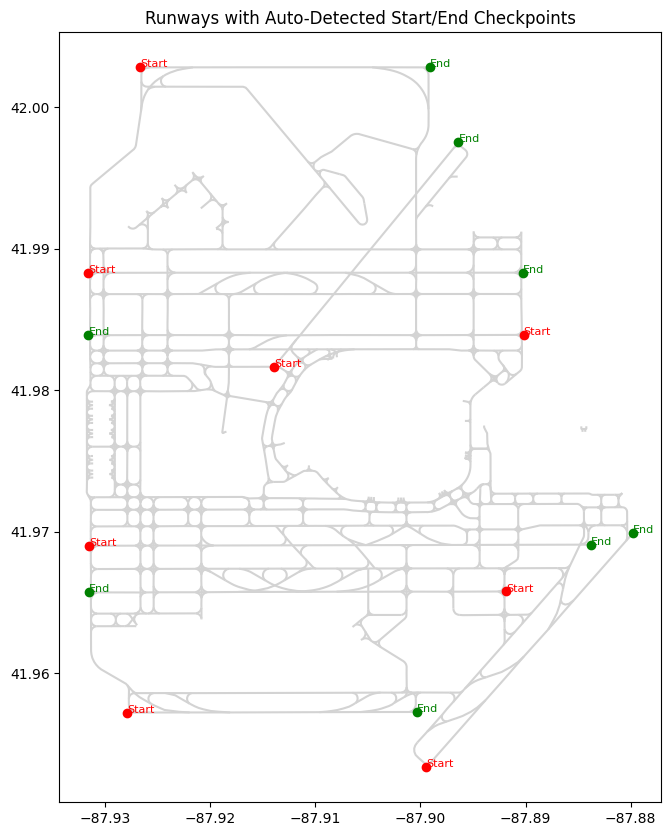

In [9]:
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# tags and place
tags = {"aeroway": ["taxiway", "runway"]}
place = "O'Hare International Airport, Chicago, Illinois, USA"
gdf = ox.features_from_place(place, tags)

# filter for runway only
runways = gdf[gdf["aeroway"] == "runway"]

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightgray')

# loops through each runway and extract endpoints
# for each runway, it checks if it is a LineString (most are), it extracts the first and last coordinate pair from the line and plots them
for idx, row in runways.iterrows():
    geom = row.geometry
    if isinstance(geom, LineString):
        start = geom.coords[0]
        end = geom.coords[-1]

        # Plot start and end
        ax.plot(start[0], start[1], 'ro')  # red = start
        ax.plot(end[0], end[1], 'go')      # green = end

        # Optional labels
        ax.text(start[0], start[1], 'Start', fontsize=8, color='red')
        ax.text(end[0], end[1], 'End', fontsize=8, color='green')

plt.title("Runways with Auto-Detected Start/End Checkpoints")
plt.show()

In [13]:
!git init
!git add Airport_map.ipynb
!git commit -m "Initial commit: airport mapping with osmnx"
!git remote add origin https://github.com/debaryasaha/aida3-ugr.git
!git branch -M main
!git push -u origin main

Reinitialized existing Git repository in /home/jupyter/.git/
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: empty ident name (for <jupyter@instance-20250417-122331.us-central1-a.c.aida3ml.internal>) not allowed
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/debaryasaha/aida3-ugr.git'


In [ ]:
git config --global user.email "debarya.saha@gmail.com"
